# Travail personnel 1 : Kepler et RK4
#### Cordier Alix & Vandepopeliere Romain - BA3 PHYS

## Mise en situation
Les première étapes consisteront à importer les librairies requises et ensuite d'implémenter les valeurs des constantes et des conditions initiales. Pour ces dernières nous avons choisi de placer le centre de la terre en $(0,0)$ du plan $xy$, d'imaginer le périhélie vers les $x$ négatifs et de choisir la vitesse initiale dirigée vers les $y$ positifs comme sur le schéma de l'énoncé.

<img src="figs/ellipse.png" alt="Drawing" style="width: 400px;"/>

In [2]:
from math import sin, cos, log, ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [3]:
## constantes
G=6.67408*10**(-11)  # m^3.kg^-1.s^-2
mT=5.972*10**24      # kg    (masse de la Terre)
mL=7.348*10**22      # kg    (masse de la Lune)

## données
rmin=362600000.0     # m
Vpér=1083.4          # m.s^-1

## conditions initiales
x0=-rmin             # m
y0=0.0               # m
vx0=0.0              # m.s^-1
vy0=Vpér             # m.s^-1

En plaçant le centre de la Terre à l'origine $(0,0)$ et en repérant la Lune avec le vecteur $\vec{r}=(x,y)$, on obtient l'équation vectorielle:

$$\frac{d^2\vec{r}}{dt^2} = - \frac{Gm_T}{r^3}\vec{r}$$
et donc le système d'équations : 
$$ \frac{d^2x}{dt^2} = - \frac{Gm_T}{(x^2+y^2)^{3/2}} x   $$
$$ \frac{d^2y}{dt^2} = - \frac{Gm_T}{(x^2+y^2)^{3/2}} y   $$

puisque la Terre est fixe dans son référentiel.
Afin d'avoir des équations du premier ordre, il est judicieux d'introduire les vitesses: 
$$\frac{dx}{dt} = v_x $$
$$\frac{dy}{dt} = v_y $$
$$ \frac{dv_x}{dt} = - \frac{Gm_T}{(x^2+y^2)^{3/2}} x   $$
$$ \frac{dv_y}{dt} = - \frac{Gm_T}{(x^2+y^2)^{3/2}} y   $$

On crée alors un vecteur $\vec{u}(t)$ tel que $$\vec{u}(t) = \begin{pmatrix} x\\y\\v_x\\v_y \end{pmatrix} $$

En vue du système des 4 équations précédentes, le vecteur dérivé $\vec{u}'(t)$ sera comme suit : 

$$\vec{u}'(t) = \begin{pmatrix} v_x\\v_y\\- \frac{Gm_T}{(x^2+y^2)^{3/2}} x   \\ - \frac{Gm_T}{(x^2+y^2)^{3/2}} y\end{pmatrix} $$

## Question 1

Avant de commencer, on implémente la méthode Runge-Kutta 4. 

In [4]:
def rk4_step(u,f,dt):
    
    k1=f(u)
    k2=f(u+dt*k1/2)
    k3=f(u+dt*k2/2)
    k4=f(u+dt*k3)
    
    return u+(k1+2*k2+2*k3+k4)*dt/6

Ensuite, on peut également implémenter la fonction $$f(\vec{u})=\vec{u}'$$

In [5]:
def f(u):
    
    x=u[0]
    y=u[1]
    vx=u[2]
    vy=u[3]
    r=(x**2+y**2)**(3/2)
    c=-G*mT/r
    
    return numpy.array([vx,vy,c*x,c*y])

Sachant que la période de révolution de la Lune est un peu inférieure à 30 jours, on choisit de chercher la trajectoire pour une durée de 30 jours pour être sûrs qu'il y a aura au moins une révolution entière.

In [6]:
T=86400*30              # 30 jours
dt=1                    # seconde
N=int(T/dt)+1           # nombre de time steps

u=numpy.empty((N,4))                # on prépare le tableau de solutions
u[0]=numpy.array([x0,y0,vx0,vy0])   # conditions initiales

for t in range(N-1):                # exécution de la méthode RK4              
    u[t+1]=rk4_step(u[t],f,dt)

Portons en graphique la trajectoire obtenue:

In [7]:
x_traj=u[:,0]
y_traj=u[:,1]

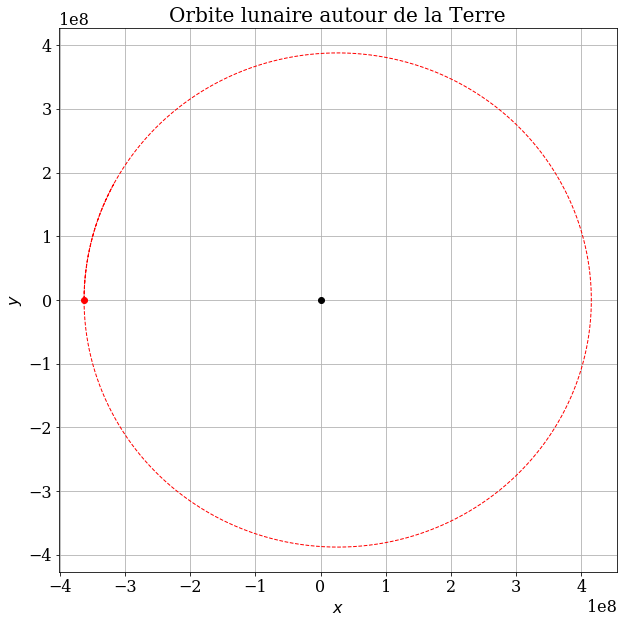

In [8]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Orbite lunaire autour de la Terre',fontsize=20)
pyplot.plot (x_traj,y_traj,'r--',lw=1)
pyplot.plot (0,0,'ko')
pyplot.plot (x0,0,'ro')

Le point noir représente la position de la Terre et le point rouge celle dans la lune en $t=0$.

##### Remarques
1) Comme le T est choisi est supérieur à la période, il est normal de voir une superposition de trajectoires après une révolution entière.

2) Le calcul d'excentricité de l'ellipse obtenue et la comparaison avec la trajectoire théorique seront effectués après la question 2.

## Question 2

Nous allons maintenant chercher les valeurs du demi-grand axe et du demi-petit axe.
Pour ce faire, on va calculer la distance qui sépare $x_{min}$ de $x_{max}$ (=grand axe) et ensuite celle qui sépare $y_{min}$ de $y_{max}$ (=petit axe).

Comme l'ellipse est centrée verticalement, commençons par chercher les endroits de la trajectoire qui coupent l'axe $x$ pour trouver  $x_{min}$ et $x_{max}$. Pour cela, on va affiner un intervalle de distance autour de $y=0$ avec la fonction numpy.where jusqu'à ce qu'on n'ait plus que 3 indices, correspondant (approximativement) aux 3 intersections avec l'axe x que l'on voit sur le graphique (on estime qu'un intervalle de l'ordre de la centaine de mètres est correct par rapport à la longueur des axes de l'ellipse qui seront de l'ordre de la centaine de milliers de kilomètres). Prenons donc les indices relatifs aux 2 premières intersections (la 3ème correspondant à la Lune qui repasse par le point initial pour recommencer un tour).

In [9]:
idx_extr=numpy.where(abs(y_traj)<=450.0)[0]
print(idx_extr)

[      0 1207202 2414403]


In [10]:
xmin=x_traj[idx_extr[0]]  # on cherche les x correspondant aux indices trouvés
xmax=x_traj[idx_extr[1]]
print(xmin)
print(xmax)

-362600000.0
415353549.349


On peut maintenant calculer le demi-grand axe a:

In [11]:
a=abs(xmin-xmax)/2
print(a)

388976774.675


Pour le demi-petit axe, c'est plus compliqué car l'ellipse n'est pas centrée horizontalement. On va donc calculer les coordonnées du centre de l'ellipse (on peut le faire maintenant qu'on connait $x_{min}$ et $x_{max}$) pour ensuite décaler toute l'ellipse afin de ramener son centre en $(0,0)$ et ainsi pouvoir étudier le petit axe au moyen des intersections avec l'axe y. Cette fois, en vue du graphique, on s'attend à trouver les indices de 2 intersections : $y_{min}$ et $y_{max}$.

In [12]:
centre=(xmax+xmin)/2
print(centre)

26376774.6747


In [13]:
x_traj_centree=x_traj-centre   # on décale l'ellipse

On affine un intervalle de distance autour de x=0:

In [14]:
idy_extr=numpy.where(abs(x_traj_centree)<=505)[0]
print(idy_extr)

[ 577544 1836859]


In [15]:
ymax=y_traj[idy_extr[0]]  # on cherche les y correspondant aux indices trouvés
ymin=y_traj[idy_extr[1]]

Et on calcule le demi-petit axe b:

In [16]:
b=abs(ymin-ymax)/2
print(b)

388081430.88


Ainsi, on obtient finalement les résultats pour $a$ le demi-grand axe et $b$ le demi-petit axe : 
$$a = 3,88976774.10^8m$$
$$b = 3,88081430.10^8m$$

Une autre manière de procéder pour obtenir les valeurs des demi-axes aurait par exemple été de créer des listes contenant les indices relatifs aux points de la trajectoire présents sur 1/4 de l'ellipse. Par exemple, pour trouver $y_{max}$, on aurait pu utiliser un numpy.where pour trouver les indices des points de y positif et un autre pour ceux de vy positif. En utilisant numpy.intersect1d pour les 2 tableaux obtenus, on aurait alors obtenu l'ensemble des indices relatifs aux points du 1er quadrant de l'ellipse, et le dernier élément du tableau aurait été l'indice relatif à $y_{max}$. On a obtenu les mêmes résultats pour a et b avec cette méthode, mais celle-ci n'est pas applicable lorsqu'on a une solution pour un temps supérieur à la période.

#### Valeurs théoriques des demi-axes

On sait que l'ellipse théorique a pour équation:

$$r(\theta)=\frac{r_{min}(1+\epsilon)}{1+\epsilon \cos\theta}.$$ 
avec l'excentricité $$\epsilon = 0.0549006$$

On peut donc en déduire les valeurs théoriques de $x_{min}$ et $x_{max}$ :

In [18]:
e=0.0549006
pi=3.14159265358979

def X_theo(theta):                     # prend un angle et renvoie l'abscisse du point de l'ellipse correspondant
    r_theo=rmin*(1+e)/(1+e*cos(theta))
    return r_theo*cos(theta)

def Y_theo(theta):                     # idem avec l'ordonnée
    r_theo=rmin*(1+e)/(1+e*cos(theta))
    return r_theo*sin(theta)

xmin_theo=X_theo(pi)                   # calcul des 4 points théoriques
xmax_theo=X_theo(0)

a_theo=abs(xmin_theo-xmax_theo)/2      # calcul des demi-axes théoriques

print('Demi-grand axe théorique: a_theo = {:.3f}'.format(a_theo))

Demi-grand axe théorique: a_theo = 383663348.003


La formule de l'excentricité $e$ est donnée par:

$$e=\frac{\sqrt{a^2-b^2}}{a}$$

Vu qu'on connaît maintenant l'excentricité théorique et le demi-grand axe théorique, on peut alors facilement déterminer le demi petit axe théorique:

$$b=a\sqrt{1-e^2}$$

In [21]:
b_theo=a_theo*(1-e**2)**(1/2)
print('Demi-petit axe théorique: b_theo = {:.3f}'.format(b_theo))

Demi-petit axe théorique: b_theo = 383084716.443


#### Calcul de l'excentricité de l'ellipse obtenue numériquement

On a vu juste au-dessus la formule qui relie l'excentricité aux demi-axes. En reprenant les valeurs des demi-axes de l'ellipse obtenue avec RK4, calculés précédemment, on trouve:

In [102]:
e_num=(a**2-b**2)**(1/2)/a
print(e_num)

0.0678106673571


On obtient donc une excentricité valant $$e=0.06781$$

#### Tracé théorique de l'ellipse et comparaison avec celle obtenue avec RK4

On peut obtenir le tracé de l'ellipse à partir de l'équation paramétrique vue précédement.

In [164]:
two_pi=2*pi
n=10000
theta=numpy.linspace(0.0,two_pi,n)
x_theo=numpy.empty(n)
y_theo=numpy.empty(n)

In [171]:
for i in range(n):
    x_theo[i]=X_theo(theta[i])
    y_theo[i]=Y_theo(theta[i])

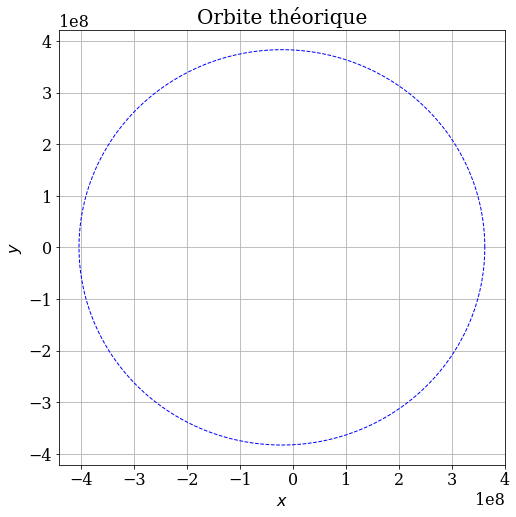

In [174]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Orbite théorique',fontsize=20)
pyplot.plot (x_theo,y_theo, 'b--',lw=1)

Pour qu'une comparaison sur le même graphique ait un sens, il faut recentrer les deux ellipses. Le travail a déjà été réalisé pour l'ellipse "expérimentale"; il faut donc appliquer le même procédé pour la théorique (on remarque que, de nouveau, l'ellipse est déjà centrée verticalement).

In [175]:
idx_extr_th=numpy.where(abs(y_theo)<=210000.0)[0]     # l'intervalle est plus grand qu'avant car il y a beaucoup moins 
print(idx_extr_th)                                    # de points qui constituent la trajectoire

[   0 4999 5000 9999]


In [176]:
xmin_th=x_theo[idx_extr_th[0]]     # on cherche les x correspondant aux indices trouvés
xmax_th=x_theo[idx_extr_th[1]]

In [177]:
centre_th=(xmax_th+xmin_th)/2      # centre de l'ellipse théorique
print(centre_th)

-21063337.435


In [178]:
x_theo_centree=x_theo-centre_th    # ellipse théorique décalée

On peut maintenant comparer graphiquement les 2 ellipses:

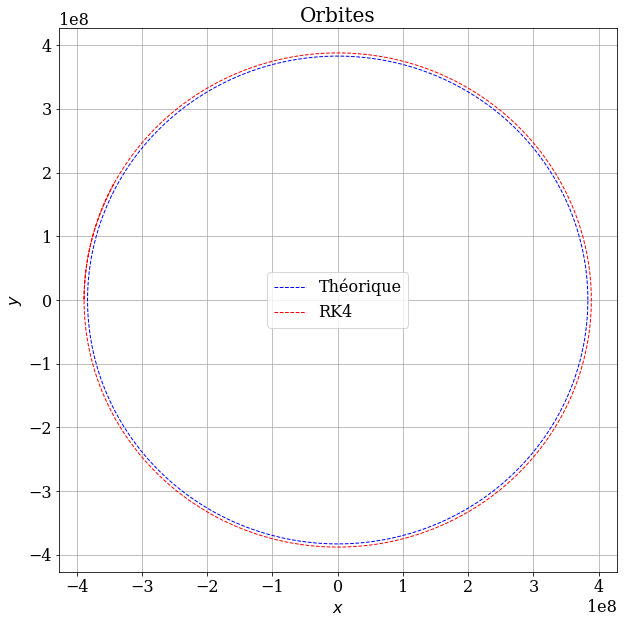

In [179]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Orbites',fontsize=20)
pyplot.plot (x_theo_centree,y_theo, 'b--',lw=1,label='Théorique')
pyplot.plot (x_traj_centree,y_traj, 'r--',lw=1,label='RK4')
pyplot.legend()

Les deux ellipses sont donc très semblables, bien que celle calculée théoriquement soit un peu plus petite que celle obtenue numériquement (ce qu'on pouvait déjà remarquer à partir des valeurs de demi-axes obtenues précédemment).

## Question 3 

La réponse à cette question est directement donnée par ce qu'on a fait au début de la question 2. En effet, on a trouvé les indices des 3 intersections de la trajectoire avec l'axe $x$ et il suffit donc de comparer l'indice de la 1ère intersection avec celui de la 3ème. Vu les conditions initiales, il est logique que l'indice de la première intersection soit 0 et que la période soit donc donnée par l'indice de la 3ème intersection (le pas $dt$ valant 1 seconde, l'indice est donc direcement le nombre de secondes écoulées depuis l'instant 0).

In [103]:
periode=idx_extr[2]
print(periode)
periode_en_jours=periode/84600
print(periode_en_jours)

2414403
28.5390425532


On obtient donc une période $ T=28,53904 j.$

*Remarque*: en prenant le dernier élément d'un tableau d'indices relatifs aux points de y négatif et de vy positif, on trouve également la même valeur pour la période.

#### Période théorique

La formule théorique de la période pour ce genre de problème est donnée par (cf. Syllabus de Pierre Gaspard, MATH F204-Mécanique Analytique, 5.4 "Le problème de Kepler") : $$T=\frac{2\pi a^{3/2}}{\sqrt{G(m_T+m_L)}}$$


In [159]:
periode_theo=2*pi*a_theo**(3/2)/(G*(mT+mL))**(1/2)
print(periode_theo)
periode_theo_en_jours=periode_theo/86400
print(periode_theo_en_jours)

2350683.9301896733
27.206989932750847


En prenant notre valeur théorique du demi-grand axe $a$, on obtient comme période théorique $T_{th}=27,20699j$, ce qui se rapproche de ce que l'on a obtenu. 

## Question 4

Nous allons maintenant tenter de vérifier si la méthode RK4 utilisée se comporte bien de la façon attendue, c'est-à-dire si on observe bien un ordre de convergence proche de 4 pour cette méthode.
Dans un premier temps, nous allons vérifier cela de façon graphique.

On commence par chercher plusieurs trajectoires avec différents pas de temps:

In [122]:
dt_values = numpy.array([10000, 5000, 2000, 1000, 500])

s_values = numpy.empty_like(dt_values, dtype=numpy.ndarray) # on prépare le tableau des solutions

for i, dT in enumerate(dt_values):
    
    N = int(periode/dT)+1                # nombre de time steps              
    t = numpy.linspace(0.0, periode, N)  # time grid
    
    s = numpy.empty((N, 4))              # on prépare le tableau des solutions pour un dT particulier
    s[0] = numpy.array([x0,y0,vx0,vy0])  # conditions initiales

    for n in range(N-1):                 # RK4
        s[n+1] = rk4_step(s[n], f, dT)
    
    s_values[i] = s

On définit la fonction get_diffgrid qui va servir à obtenir la différence entre 2 solutions numériques et qui en prendra ensuite la norme $L_1$ de cette différence (de tableaux).

In [123]:
def get_diffgrid(u_current, u_fine, dT):
    
    N_current = len(u_current[:,0])
    N_fine = len(u_fine[:,0])
   
    grid_size_ratio = ceil(N_fine/N_current)
    
    diffgrid = dT * numpy.sum( numpy.abs(\
            u_current[:,0]- u_fine[::grid_size_ratio,0])) 
    
    return diffgrid

On cherche alors la norme $L_1$de la différence entre chaque solution numérique et celle qui possède le plus petit pas (ici, 500 secondes).

In [124]:
diffgrid = numpy.empty_like(dt_values)      # tableau qui contiendra les normes

for i, dT in enumerate(dt_values):

    diffgrid[i] = get_diffgrid(s_values[i], s_values[-1], dT)

print(diffgrid)

[28856886  1725077    42796     2485        0]


On porte ces valeurs (sauf la dernière) en graphique en fonction du pas de temps:

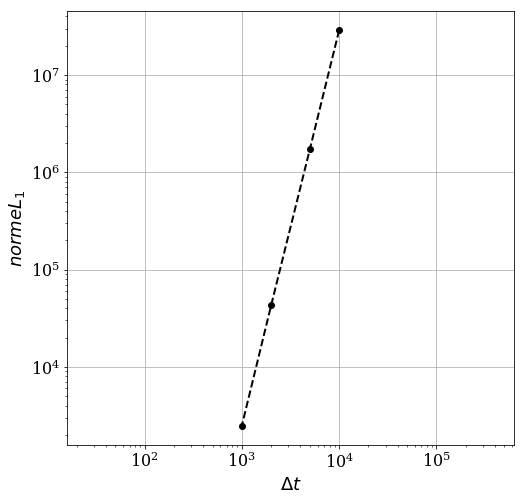

In [119]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$norme L_1$', fontsize=18)
pyplot.axis('equal')
pyplot.loglog(dt_values[:-1], diffgrid[:-1], color='k', ls='--', lw=2, marker='o');

Globalement, on semble obtenir un bon résultat: les normes des différences entre chaque solution et celle de plus petit pas diminuent rapidement avec le pas de temps. De plus, on peut observer graphiquement que la pente de la droite obtenue est environ 4.

Pour étudier plus précisément la convergence de notre méthode, on peut calculer l'ordre de convergence p observé. Pour ce faire, on utilise 3 solutions numériques dont les pas diffèrent à un rapport r constant et on utilise la formule:

$$ p=\frac{\log{\frac{f_3-f_2}{f_2-f_1}}}{\log{r}} $$

( $f_1$ et $f_3$ correspondant à la solution de plus petit pas et de plus grand pas respectivement)

In [125]:
r = 2               # ratio
h = 3600            # pas

dt_values = numpy.array([h, r*h, r**2*h])

s_values = numpy.empty_like(dt_values, dtype=numpy.ndarray) # tableau solutions

diffgrid = numpy.empty(2) 

for i, dT in enumerate(dt_values):
    
    N = int(periode/dT) + 1 

    s = numpy.empty((N, 4))
    s[0] = numpy.array([x0,y0,vx0,vy0])

    for n in range(N-1):

        s[n+1] = rk4_step(s[n], f, dT)
    
    s_values[i] = s
    

### f2 - f1
diffgrid[0] = get_diffgrid(s_values[1], s_values[0], dt_values[1])

### f3 - f2
diffgrid[1] = get_diffgrid(s_values[2], s_values[1], dt_values[2])

### ordre de cvgce
p = (log(diffgrid[1])-log(diffgrid[0])) / log(r)

print('Ordre de convergence: p = {:.3f}'.format(p));

Ordre de convergence: p = 4.092


*Remarque:* on a choisi des valeurs de h beaucoup plus élevées qu'une seconde parce que les valeurs de pas très petites par rapport à l'échelle de temps du problème (1, 2 et 4 secondes par exemple) ne sont pas adaptées pour un calcul d'ordre de convergence.

## Question 5

Soit $\vec{w}$ le vecteur qui décrira la position et la vitesse de l'astéroïde. Il y aura 2 forces qui agissent sur l'astéroïde : la force gravitationnelle exercée par la Terre et la force gravitationnelle exercée par la Lune. Ainsi, les dérivées des vitesses dépendront de la distance entre l'astéroïde et la terre (équivalente à la position de l'astéroïde puisque la terre est en $(0,0)$) et de la distance entre l'astéroïde et la lune (d'où les facteurs $(x_a-x_L)$ et $(y_a-y_L)$ avec $(x_L,y_L)$ la position de la lune).

*Remarque:* bien entendu, on suppose que l'astéroïde n'influence pas le système Terre-Lune et donc que la trajectoire de la Lune précédemment calculée est toujours valable.

$$\vec{w}(t) = \begin{pmatrix} x_a\\y_a\\v_{x,a}\\v_{y,a}\end{pmatrix}$$

$$\vec{w}'(t) = \begin{pmatrix} v_{x,a}\\v_{y,a}\\-G \frac{m_T}{(x_a^2+y_a^2)^{3/2}} x_a -G \frac{m_L}{((x_a-x_L)^2+(y_a-y_L)^2)^{3/2}} (x_a-x_L)  \\ -G \frac{m_T}{(x_a^2+y_a^2)^{3/2}} y_a -G \frac{m_L}{((x_a-x_L)^2+(y_a-y_L)^2)^{3/2}} (y_a-y_L)  \end{pmatrix}. $$

On pose à nouveau une fonction:

$$g(\vec{w})=\vec{w}' $$

La fonction $g$ va dépendre du temps car, bien que la terre reste en $(0,0)$, la lune bouge et donc ses coordonnées $(x_L,y_L)$ (reprises dans x_traj et y_traj) vont évoluer au cours du temps.

In [136]:
def g(u,t):
    
    xa=u[0]
    ya=u[1]
    vxa=u[2]
    vya=u[3]
    
    i=int(t)                     # RK4 donnera des temps non entiers en input, ce qui pose problème car i doit être un indice
    distT_a3=(xa**2+ya**2)**(3/2)                 
    distL_a3=((xa-x_traj[i])**2+(ya-y_traj[i])**2)**(3/2)
    
    return numpy.array([vxa , vya , -G*mT*xa/distT_a3 - G*mL*(xa-x_traj[i])/distL_a3  , -G*mT*ya/distT_a3 - G*mL*(ya-y_traj[i])/distL_a3])

Grâce aux calculs des intersections de la trajectoire de la lune avec l'axe $x$, on sait qu'elle est à l'apogée en $$t_0=1207202 s  $$
Introduisons $t'=t-t_0$ qui sera le temps écoulé depuis que la lune a passé son apogée (sachant que t est le temps écoulé depuis qu'elle a commencé sa révolution).

De plus, on a aussi calculé le centre de l'ellipse : $(26376774.6747,0)$

In [137]:
###Paramètres
dt_a = 1
T_a = 14*86400           # étude de la trajectoire sur 14 jours
N_a=int(T_a / dt_a) +1

###Conditions initiales
xa0 = 26376774.6747      # centre de l'ellipse
ya0 = 0.0                # centre de l'ellipse
vxa0 = -500.0
vya0 = 500.0
t0= 1207202

Il faut redéfinir la méthode RK4 pour une fonction dépendant du temps:

In [138]:
def rk4_step_t(u,f,t,dt):
    
    k1=f(u,t)
    k2=f(u+dt*k1/2,t+dt/2)
    k3=f(u+dt*k2/2,t+dt/2)
    k4=f(u+dt*k3,t+dt)
    
    return u+(k1+2*k2+2*k3+k4)*dt/6

In [139]:
w=numpy.empty((N_a,4))                 # tableau de solutions
w[0]=numpy.array([xa0,ya0,vxa0,vya0])  # conditions initiales

Lorsque l'astéroïde "apparait", on est en $t'=0$.  Dans RK4, ll ne faut donc pas oublier de shifter le temps de + $t_0$ pour qu'en $t'=0$, on ait bien la force exercée par la lune sur l'astéroïde au moment où celle-ci est à l'apogée.

In [140]:
for i in range(N_a-1):              
    w[i+1]=rk4_step_t(w[i],g,i+t0,dt_a)      

On porte en graphique la trajectoire de l'astéroïde:

In [180]:
x_traj_a=w[:,0]
y_traj_a=w[:,1]

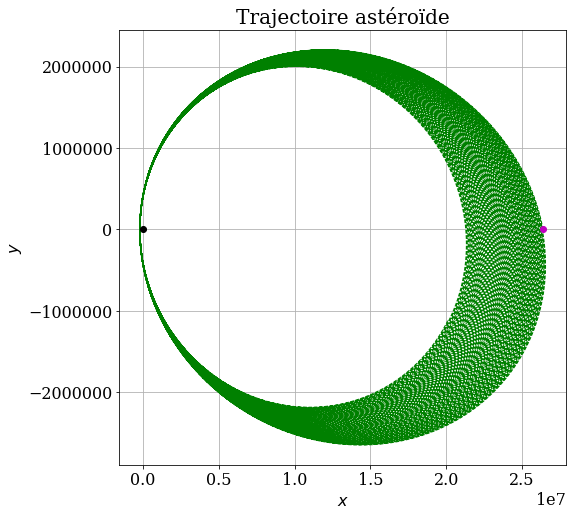

In [181]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Trajectoire astéroïde',fontsize=20)
pyplot.plot (x_traj_a,y_traj_a, 'g--',lw=1)
pyplot.plot (xa0,ya0,'mo')
pyplot.plot (0,0,'ko')

Le point noir représente la position de la Terre, le rose la position de l'astéroïde en $t'=0$. On remarque en fait que l'astéroïde devrait s'écraser sur la Terre. Nous allons faire apparaitre le contour de la Terre pour s'en rendre compte (en supposant que la terre est sphérique).

In [182]:
rayon=6400000      # rayon de la Terre
n=1000
x_terre=numpy.empty(n)
y_terre=numpy.empty(n)
theta=numpy.linspace(-numpy.pi,numpy.pi,n)
for i in range(n-1):
    x_terre[i]=rayon*cos(theta[i])
    y_terre[i]=rayon*sin(theta[i])

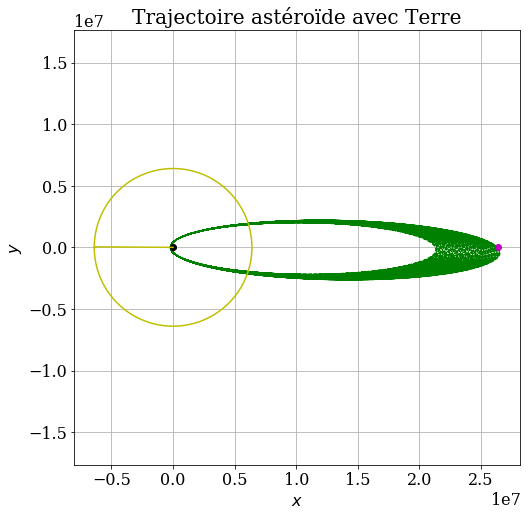

In [183]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Trajectoire astéroïde avec Terre',fontsize=20)
pyplot.axes().set_aspect('equal','datalim')
pyplot.plot (x_traj_a,y_traj_a, 'g--',lw=1)
pyplot.plot (xa0,ya0,'mo')
pyplot.plot (0,0,'ko')
pyplot.plot (x_terre,y_terre, 'y-')

Représentons maintenant cette trajectoire vis-à-vis de celle de la Lune.

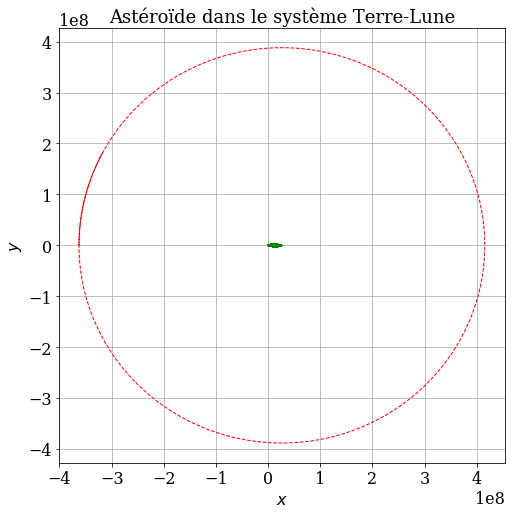

In [184]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Astéroïde dans le système Terre-Lune',fontsize=18)
pyplot.plot (x_traj_a,y_traj_a, 'g--',lw=1)
pyplot.plot (x_traj,y_traj, 'r--',lw=1)

Etant donné la position initiale de l'astéroïde qui est très proche du centre de la terre, celui-ci est directement "happé" par la gravitation terrestre alors que la lune, beaucoup moins massive que la terre et étant très loin de là, n'a quasiment aucune influence sur la trajectoire de l'astéroïde.

## Question 6

Pour faire l'animation, il va falloir recalculer la trajectoire de la Lune avec moins d'itérations sinon l'animation serait beaucoup trop lourde, sachant que chaque itération correspondra à une image (frame).

Cependant, pour l'astéroïde, nous allons simplement représenter 1 position toutes les 1000 positions (si $dt=1000$). On aurait pu pratiquer de la sorte pour la Lune mais on préférait avoir un indice simple pour itérer.

In [148]:
from matplotlib import animation
from IPython.display import HTML

In [149]:
dt=1000             # secondes
T=periode
N=int(T/dt)+1       # nombre de time steps

u_modif=numpy.empty((N,4))
u_modif[0]=numpy.array([x0,y0,vx0,vy0])

In [150]:
for t in range(N-1):              
    u_modif[t+1]=rk4_step(u_modif[t],f,dt)

In [151]:
x_traj_modif=u_modif[:,0]
y_traj_modif=u_modif[:,1]

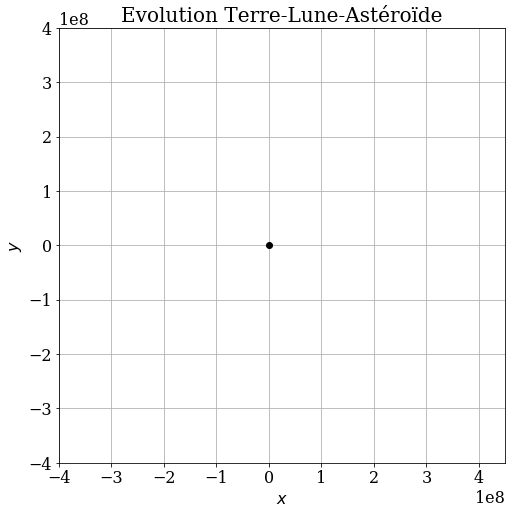

In [152]:
fig = pyplot.figure(figsize=(8,8))
ax = pyplot.axes(xlim=(-4*10**8,4.5*10**8), ylim=(-4*10**8,4*10**8))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('Evolution Terre-Lune-Astéroïde',fontsize=20)
lineL= ax.plot([], [], 'ro')[0]
lineT= ax.plot(0,0, 'ko')[0]              # la line de la terre n'est pas vide de base car elle restera fixe
lineA=ax.plot([],[],'go')[0]

In [153]:
def init():         
    lineL.set_data([], [])
    lineA.set_data([], [])
    return lineL,lineA

In [154]:
def animate(i):
    t=i
    lineL.set_data(x_trajtest[t], y_trajtest[t])             #La position de la lune est à indiquer quelque soit t.
    if(t>=int(t0/dt) and t<=((N_a+t0)/dt)):                  #on indique la position de l'astéroïde à partir du moment
        lineA.set_data(x_traj_a[t*dt-t0],y_traj_a[t*dt-t0])  #où la lune est à l'apogée (t0) et jusqu'à 14 jours après.
    else:                                                    #Attention au décalage de t0 et aux valeurs à sélectionner tous
        lineA.set_data([], [])                               #les 1000 indices.
    return lineL,lineA

In [155]:
anim = animation.FuncAnimation(fig, animate, frames=N, interval=10, init_func=init,repeat=False)

In [ ]:
HTML(anim.to_html5_video())

Bien entendu, sur cette animation, les positions sont les suivantes : terre en noir, lune en rouge et astéroïde en vert. Pour une animation moins saccadée au niveau de l'astéroïde (celui-ci se déplace à très grande vitesse autour du point $(0,0)$), on peut réduire le pas $dt$ mais cela va augmenter le nombre de frames à charger pour l'animation, sachant que celle qui est ici présentée recquiert 5 min de calcul.